2021.07.19 臭氧分鐘值計算_使用Dask

方法: O3 滾動式5分鐘平均值(挑2個)，7點之後第1次O3分鐘值超過71，的當分鐘(平均值)與前60分鐘(平均值)的**斜率**
- 2018~2020 超標日，的**斜率範圍/統計**
- 2018~2020 非超標日，的**斜率範圍/統計**

資料來源: 國家級分鐘值
- 2018: https://drive.google.com/drive/u/3/folders/1DW3XKadiPNxD6GnuuU4XHHlkotS1oSWZ

- 2019: https://drive.google.com/drive/u/3/folders/1eW7YXoTY4k83ix4vC7ulQcwlVOSDoyGB

- 2020: https://drive.google.com/drive/u/0/folders/1dlduun3eQ-aXqRsgQ24owsJbVfzIlVRb

挑戰:
-  本機端RAM: 16G， 上面每一年的檔案大小約10G，總共約30G(解壓縮前)，解壓縮後近60G，超過RAM負荷
    1. 先使用Dask分布是運算來先降維度，再使用Pandas
    2. 使用Pandas + glob 循環式計算存檔

Dask 限制:
1. Dask 不支援 多個欄位的 sort_values
2. Dask 中用到 df.loc[mask,cols]時，要改寫成: dask.dataframe.Series.mask >> df[cols].mask(mask)；或分成兩段式 df_mask = df[mask]
3. groupby+rolling 方法 Dask 尚未支援 >> 單純使用rolling OK
4. groupby + head 方法 Dask 尚未支援 >> 將 head 改成 first >> 但是跟預期的效果不同...
5. 以TimeStamp reindex dask dataframe 會出錯

Pandas + glob 限制:
1. 檔案之間的銜接處無法處裡
2. 以loop方式讀檔，無法平行化處裡

In [132]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

import dask.dataframe as dd
from dask.delayed import delayed

import os
import shutil
from glob import glob
from zipfile import ZipFile

# 檔案解壓縮

歸類>解壓縮>挑選>解壓縮

第1層解壓縮

In [46]:
# 觀察 雲端壓縮檔有幾包，取得包名稱
path = "E:\臭氧分鐘值_2018to2020"
cloud_path_lst = glob(path + '\/\/*.zip')
cloud_path_name_set = set(p.split("drive-download-")[-1].split("-")[0] for p in cloud_path_lst)
print(f">> 從雲端下載了共: {len(cloud_path_name_set)}包\n{cloud_path_name_set}\n")

# 在目錄下建立包名資料夾，並解壓縮
for c_name in cloud_path_name_set:
    folder_path = path + "\/\/" + c_name
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        print(f"\n>> {c_name} 資料夾建立完畢")
        
        # 解壓縮檔案至此
        path_for_extractall_lst = [p for p in cloud_path_lst if (c_name in p)]
        for p4e in path_for_extractall_lst:
            print(p4e)
            zf = ZipFile(p4e, 'r')
            zf.extractall(folder_path)
            zf.close()
            
            # 把解壓縮過的檔案搬移至 Raw資料夾(先手動建立一個)
            p4e_new = "\\".join([path, "Raw", p4e.split("\\")[-1]])
#             print(p4e_new)
            shutil.move(p4e, p4e_new)
        print("\n")
print("\n>> 第1層 解壓縮完畢!!")

>> 從雲端下載了共: 0包
set()


>> 第1層 解壓縮完畢!!


In [52]:
cloud_path_name_set = set({"20210719T004203Z", "20210719T004155Z", })
# 

In [53]:
cloud_path_name_set

{'20210719T004155Z', '20210719T004203Z'}

第2層解壓縮

In [54]:
for c_name in cloud_path_name_set:
    folder_path = path + "\/\/" + c_name
        
    #進入各月份資料夾
    for m in range(1, 12+1):
        m_str = str(m).zfill(2)
    # Vfile_lst = glob(folder_path + f"\\{m_str}\\*_垂直資料_?.zip")
        Hfile_lst = glob(folder_path + f"\\{m_str}\\*_橫向資料_?.zip")
    #     print(Vfile_lst)
    #     print("\n")
        print(Hfile_lst)
        for _p4e in Hfile_lst:
            zf = ZipFile(_p4e, 'r')
            zf.extractall(folder_path)
            zf.close()
print("\n>> 第2層 解壓縮完畢!!")

['E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\01\\481_國家級測站分鐘值_2020_01_橫向資料_1.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\01\\481_國家級測站分鐘值_2020_01_橫向資料_2.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\01\\481_國家級測站分鐘值_2020_01_橫向資料_3.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\01\\481_國家級測站分鐘值_2020_01_橫向資料_4.zip']
['E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\02\\481_國家級測站分鐘值_2020_02_橫向資料_1.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\02\\481_國家級測站分鐘值_2020_02_橫向資料_2.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\02\\481_國家級測站分鐘值_2020_02_橫向資料_3.zip']
['E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\03\\481_國家級測站分鐘值_2020_03_橫向資料_1.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\03\\481_國家級測站分鐘值_2020_03_橫向資料_2.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\03\\481_國家級測站分鐘值_2020_03_橫向資料_3.zip', 'E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\03\\481_國家級測站分鐘值_2020_03_橫向資料_4.zip']
['E:\\臭氧分鐘值_2018to2020\\/\\/20210719T004203Z\\04\\481_國家級測站分鐘值_2020_04_橫向資料_1.zip', 

# Pandas Dataframe + glob

## 提前1小時

In [393]:
# 讀檔
path = r"E:\臭氧分鐘值_2018to2020\20210719T004146Z\481_國家級測站分鐘值_2018_*_*.csv"
file_lst = glob(path)

target_df_all = pd.DataFrame()
for file in tqdm(file_lst):
    df_min = pd.read_csv(file, parse_dates=["TIME"], usecols=[0,3,124], dtype={0:"category", 124:"float32"})

    # 格式轉換
    df_min.rename(columns={"O3()":"O3_min","TIME":"DataCreationDate"}, inplace=True)
    


    # 系統運作時間 (7-1,21)
    sys_working_zone = (6,21)
    time_mask_1 = (df_min["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min["DataCreationDate"].dt.hour <= sys_working_zone[1]) 

    # 計算前五分鐘移動平均值
    # 5分鐘移動平均(MA5)，可容忍5缺2筆
    col = "O3_min"
    col_name = col+"_MA5"


    target_df_tmp = pd.DataFrame()
    # for loop 區分 SiteName
    for device_id in df_min["DEVICE_ID"].unique():
#         print(device_id)
        mask = time_mask_1 & df_min["DEVICE_ID"].isin([device_id])
        df_min_mask = df_min[mask].copy(deep=True)
        if not df_min_mask.empty:

            # 將負值設為空值
            df_min_mask.loc[df_min_mask["O3_min"]<0, "O3_min"] = np.nan

            # 創造 統一的時間區間*測站，還原缺值
            r = pd.date_range(start=df_min_mask["DataCreationDate"].min(), end=df_min_mask["DataCreationDate"].max(), freq='1min')
            df_min_mask = df_min_mask.set_index('DataCreationDate').reindex(r).fillna(
                                            {'DEVICE_ID':device_id, 'O3_min':np.nan}).rename_axis('DataCreationDate').reset_index()
            
            # 製作 Date 變數
            df_min_mask['Date'] = df_min_mask['DataCreationDate'].dt.date.apply(lambda d: d.strftime("%Y-%m-%d"))
            df_min_mask['Date'] = df_min_mask['Date'].astype('category')

            # 計算5分鐘移動平均
            df_min_mask[col_name] = df_min_mask.sort_values(by=["DataCreationDate"], ascending=[1])[col].rolling(
                                        window=5, min_periods=3, center=False).mean().apply(
                                        lambda m: round(m, 3) if pd.notna(m) else np.nan )

            # 找出每日早上7點之後(晚上9點之前)，第1次 分鐘值 超過71 的時間點與 當分鐘的MA5
            sys_working_zone = (7,21)
            time_mask_2 = (df_min_mask["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min_mask["DataCreationDate"].dt.hour <= sys_working_zone[1]) 
            mask_exceed = time_mask_2 & (df_min_mask["O3_min"] >= 71)
            target_df = df_min_mask.loc[mask_exceed, :].sort_values(['DataCreationDate'], ascending=True).groupby(["Date"]).head(1).reset_index(drop=True)


            # 找出目標分鐘前1小時的MA5，並合併 merge
            target_df.loc[:, "front_time"] = target_df['DataCreationDate'] - timedelta(hours=1)
            target_df = target_df.merge(df_min_mask, how='inner', 
                            left_on=["DEVICE_ID", "Date", 'front_time'], 
                            right_on=["DEVICE_ID", "Date", 'DataCreationDate'],
                            suffixes=("", "_front"))

            target_df_tmp = pd.concat([target_df_tmp, target_df])

        else:
            print(f">> {device_id} in {file} is empty!!")
            pass
            
    
        target_df_all = pd.concat([target_df_all, target_df_tmp])
    
target_df_all.reset_index(drop=True, inplace=True)
target_df_all.loc[:,"DEVICE_ID"] = target_df_all.loc[:,"DEVICE_ID"].astype('category')
target_df_all.loc[:,"Date"] = target_df_all.loc[:,"Date"].astype('category')
print(">> 執行完畢!")

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [10:13<00:00,  2.73s/it]

>> 執行完畢!


In [396]:
target_df_all # 目標

,DataCreationDate,DEVICE_ID,O3_min,Date,O3_min_MA5,front_time,DataCreationDate_front,O3_min_front,O3_min_MA5_front
0,2018-01-02 09:59:00,6125966040,75.050003,2018-01-02,43.103,2018-01-02 08:59:00,2018-01-02 08:59:00,0.000000,0.00
1,2018-01-16 12:39:00,6125966040,74.720001,2018-01-16,60.098,2018-01-16 11:39:00,2018-01-16 11:39:00,40.299999,42.74
2,2018-01-02 09:59:00,6125966040,75.050003,2018-01-02,43.103,2018-01-02 08:59:00,2018-01-02 08:59:00,0.000000,0.00
3,2018-01-16 12:39:00,6125966040,74.720001,2018-01-16,60.098,2018-01-16 11:39:00,2018-01-16 11:39:00,40.299999,42.74
4,2018-01-03 11:50:00,6106537758,71.099998,2018-01-03,67.180,2018-01-03 10:50:00,2018-01-03 10:50:00,43.000000,40.42
...,...,...,...,...,...,...,...,...,...
23475,2018-12-01 11:59:00,6096529303,72.099998,2018-12-01,68.220,2018-12-01 10:59:00,2018-12-01 10:59:00,47.099998,46.02
23476,2018-12-03 11:58:00,6096529303,71.500000,2018-12-03,68.320,2018-12-03 10:58:00,2018-12-03 10:58:00,43.200001,40.32
23477,2018-12-04 12:48:00,6096529303,71.199997,2018-12-04,68.420,2018-12-04 11:48:00,2018-12-04 11:48:00,54.400002,49.64
23478,2018-12-21 12:53:00,6102800520,71.199997,2018-12-21,69.160,2018-12-21 11:53:00,2018-12-21 11:53:00,65.000000,64.18


In [397]:
import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

target_df_all.info()
# 記得存檔!!
formtoPkl(target_df_all, "target_df_all_2018")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23480 entries, 0 to 23479
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataCreationDate        23480 non-null  datetime64[ns]
 1   DEVICE_ID               23480 non-null  category      
 2   O3_min                  23480 non-null  float32       
 3   Date                    23480 non-null  category      
 4   O3_min_MA5              23289 non-null  float64       
 5   front_time              23480 non-null  datetime64[ns]
 6   DataCreationDate_front  23480 non-null  datetime64[ns]
 7   O3_min_front            23215 non-null  float32       
 8   O3_min_MA5_front        23015 non-null  float64       
dtypes: category(2), datetime64[ns](3), float32(2), float64(2)
memory usage: 1.2 MB
 ==輸出備份pkl== ::: target_df_all_2018_20210721_14.15.53.pkl


In [398]:
# 讀檔
target_df_all = read_data_dir_fPathExt(r"G:\我的雲端硬碟\python\output\0721\target_df_all_2018_20210721_14.15.53.pkl")

  >> 讀取:: G:\我的雲端硬碟\python\output\0721\target_df_all_2018_20210721_14.15.53.pkl


### 計算 diff、變化率

In [399]:
target_df_all.loc[:, "diff"] = target_df_all.loc[:, "O3_min_MA5"] - target_df_all.loc[:,"O3_min_MA5_front"]
target_df_all.loc[:, "diff_ratio"] = (target_df_all.loc[:, "O3_min_MA5"] - target_df_all.loc[:,"O3_min_MA5_front"]) / target_df_all.loc[:,"O3_min_MA5_front"]

In [400]:
# DEVICE_ID 串 測站中文名
meta_path = r"E:\臭氧分鐘值_2018to2020\metedata.csv"
df_mete = pd.read_csv(meta_path, dtype={"DEVICE_ID":"str"})
df_mete.loc[:, "SiteName"] = df_mete.loc[:, "DEVICE_NAME"].apply(lambda s: s.split("-")[3].split("測站")[0])

# 串檔
target_df_all = target_df_all.merge(df_mete[["DEVICE_ID", "SiteName"]], how='left', on='DEVICE_ID')

# 修正 台臺 問題
df_mete.loc[:, "SiteName"] = df_mete.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))
target_df_all.loc[:, "SiteName"] = target_df_all.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))
target_Site_set = set(target_df_all["SiteName"].unique())

In [401]:
# target_Site_set

In [402]:
# 讀取實際超標站日
dailyMax_path = r"E:\臭氧分鐘值_2018to2020\當日最大值是否超標_2018to2020.csv"
df_dailyMax = pd.read_csv(dailyMax_path, usecols=[1,2,3,4,6])
df_dailyMax.rename(columns={"date":"Date"}, inplace=True)
print(df_dailyMax.columns)

# 修正 台臺 問題
df_dailyMax.loc[:, "SiteName"] = df_dailyMax.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))

dailyMax_Site_set = set(df_dailyMax["SiteName"].unique())
# dailyMax_Site_set

Index(['SiteName', 'Date', 'O3_8hr_max', 'O3_max', 'is_exceed_date'], dtype='object')


In [403]:
df_dailyMax[df_dailyMax["Date"].str.find("2018")>=0]["is_exceed_date"].value_counts()

False    26760
True       477
Name: is_exceed_date, dtype: int64

In [404]:
# SiteName 盤點
# target_Site_set - dailyMax_Site_set
print(f"分鐘值資料缺少 {len(dailyMax_Site_set - target_Site_set)}測站!") #
loss_Site_set = dailyMax_Site_set - target_Site_set
loss_Site_set

分鐘值資料缺少 3測站!


{'大同', '斗六', '淡水'}

In [ ]:
# # 製作比對字典
# loss_Site_DeviceID_lst= [dict(zip(df_mete.SiteName, df_mete.DEVICE_ID))[s] for s in loss_Site_set]

# # 檢查檔案
# # 讀檔
# path = r"E:\臭氧分鐘值_2018to2020\20210719T004146Z\481_國家級測站分鐘值_2018_*_*.csv"
# file_lst = glob(path)

# # target_df_all = pd.DataFrame()
# for file in tqdm(file_lst):
#     df_min = pd.read_csv(file, parse_dates=["TIME"], usecols=[0,3,124], dtype={0:"category", 124:"float32"})
#     for d_id in loss_Site_DeviceID_lst:
#         if d_id in set(df_min["DEVICE_ID"]):
#             print(f">> {dict(zip(df_mete.DEVICE_ID, df_mete.SiteName))[d_id]} 存在: {file} !\n資料數量: {len(df_min[df_min['DEVICE_ID'].isin([d_id])]}")

In [406]:
# 統一格式
# target_df_all.loc[:,"Date"] = target_df_all.loc[:,"Date"].apply(lambda d: d.strftime("%Y-%m-%d"))
df_dailyMax.loc[:,"Date"] = df_dailyMax.loc[:,"Date"].astype('category')

# 串超標日狀態 inner join
target_df_all_result = target_df_all.merge(df_dailyMax, how='inner', on=["SiteName", "Date"])
target_df_all_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20361 entries, 0 to 20360
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataCreationDate        20361 non-null  datetime64[ns]
 1   DEVICE_ID               20361 non-null  object        
 2   O3_min                  20361 non-null  float32       
 3   Date                    20361 non-null  object        
 4   O3_min_MA5              20201 non-null  float64       
 5   front_time              20361 non-null  datetime64[ns]
 6   DataCreationDate_front  20361 non-null  datetime64[ns]
 7   O3_min_front            20154 non-null  float32       
 8   O3_min_MA5_front        19952 non-null  float64       
 9   diff                    19851 non-null  float64       
 10  diff_ratio              19851 non-null  float64       
 11  SiteName                20361 non-null  object        
 12  O3_8hr_max              20361 non-null  float6

In [407]:
target_df_all_result.loc[: ,"diff_ratio"] = target_df_all_result.loc[:, "diff_ratio"].replace([np.inf, -np.inf], np.nan)

exceeed: 414
not_exceeed: 19947


Text(0.5, 1.0, ' 2018年 O3分鐘值超過71時，至前60分鐘之平均濃度變化斜率 (diff) 直方圖')

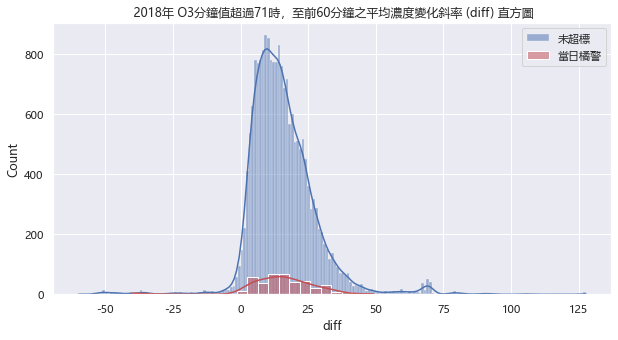

In [408]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

# 選擇變數
x = "diff"

# 拆分資料
exceeed = target_df_all_result[target_df_all_result["is_exceed_date"]]
not_exceeed = target_df_all_result[~target_df_all_result["is_exceed_date"]]

print(f"exceeed: {len(exceeed)}")
print(f"not_exceeed: {len(not_exceeed)}")

# 疊圖
fig, ax = plt.subplots(figsize=(10,5))
for idx, d in enumerate([not_exceeed, exceeed]):
    if idx==1:
        color = 'r'
        label = "當日橘警"
    else:
        color = 'b'
        label = "未超標"

    sns.histplot(data=d, x=x ,ax=ax, kde=True, color=color, label=label)
if x=="diff_ratio":
    ax.set_xlim(-0.1, 1.5)
ax.legend()
ax.set_title(f" 2018年 O3分鐘值超過71時，至前60分鐘之平均濃度變化斜率 ({x}) 直方圖")

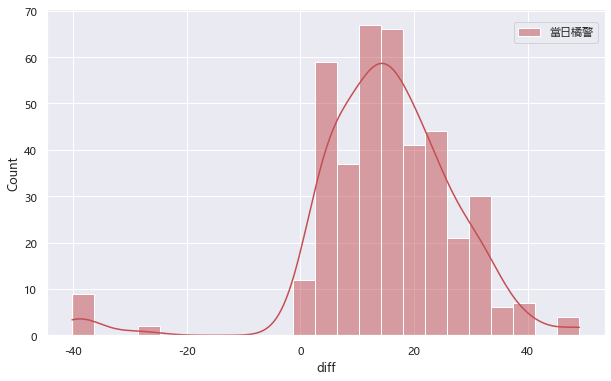

In [453]:
fig = plt.figure(figsize=(10,6))
color = 'r'
label = "當日橘警"
sns.histplot(data=exceeed, x="diff" , kde=True, color=color, label=label)
fig.legend(bbox_to_anchor=(0.89, 0.85), borderaxespad=0)

exceeed: 414
not_exceeed: 19947


Text(0.5, 1.0, ' 2018年 O3分鐘值超過71時，至前60分鐘之平均濃度變化斜率 (diff_ratio) 直方圖')

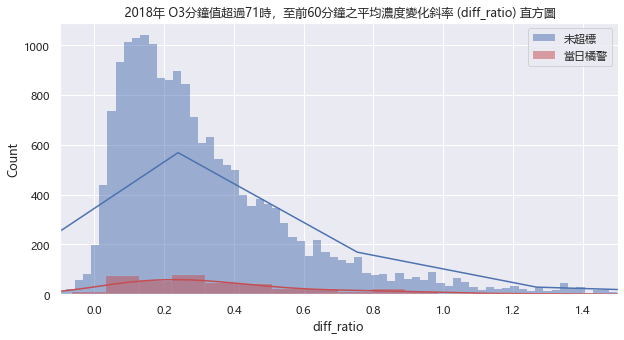

In [454]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

# 選擇變數
x = "diff_ratio"

# 拆分資料
exceeed = target_df_all_result[target_df_all_result["is_exceed_date"]]
not_exceeed = target_df_all_result[~target_df_all_result["is_exceed_date"]]

print(f"exceeed: {len(exceeed)}")
print(f"not_exceeed: {len(not_exceeed)}")

# 疊圖
fig, ax = plt.subplots(figsize=(10,5))
for idx, d in enumerate([not_exceeed, exceeed]):
    if idx==1:
        color = 'r'
        label = "當日橘警"
    else:
        color = 'b'
        label = "未超標"
        
    sns.histplot(data=d, x=x ,ax=ax, kde=True, color=color, label=label)
    
if x=="diff_ratio":
    ax.set_xlim(-0.1, 1.5)
ax.legend()
ax.set_title(f" 2018年 O3分鐘值超過71時，至前60分鐘之平均濃度變化斜率 ({x}) 直方圖")

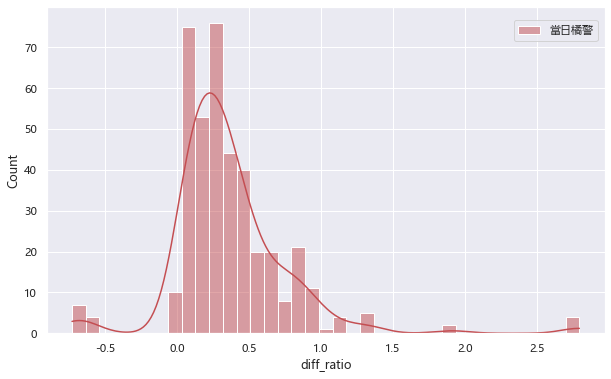

In [455]:
fig = plt.figure(figsize=(10,6))
color = 'r'
label = "當日橘警"
sns.histplot(data=exceeed, x="diff_ratio" , kde=True, color=color, label=label)
fig.legend(bbox_to_anchor=(0.89, 0.85), borderaxespad=0)

## 提前2小時 

In [456]:
early_hour = 2 # 提前小時數 (當分鐘值碰到71要往前抓提早多早的比較值)

# 讀檔
path = r"E:\臭氧分鐘值_2018to2020\20210719T004146Z\481_國家級測站分鐘值_2018_*_*.csv"
file_lst = glob(path)

target_df_all = pd.DataFrame()
for file in tqdm(file_lst):
    df_min = pd.read_csv(file, parse_dates=["TIME"], usecols=[0,3,124], dtype={0:"category", 124:"float32"})

    # 格式轉換
    df_min.rename(columns={"O3()":"O3_min","TIME":"DataCreationDate"}, inplace=True)
    


    # 系統運作時間 (7-early_hour,21)
    sys_working_zone = (7-early_hour,21)
    time_mask_1 = (df_min["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min["DataCreationDate"].dt.hour <= sys_working_zone[1]) 

    # 計算前五分鐘移動平均值
    # 5分鐘移動平均(MA5)，可容忍5缺2筆
    col = "O3_min"
    col_name = col+"_MA5"


    target_df_tmp = pd.DataFrame()
    # for loop 區分 SiteName
    for device_id in df_min["DEVICE_ID"].unique():
#         print(device_id)
        mask = time_mask_1 & df_min["DEVICE_ID"].isin([device_id])
        df_min_mask = df_min[mask].copy(deep=True)
        if not df_min_mask.empty:

            # 將負值設為空值
            df_min_mask.loc[df_min_mask["O3_min"]<0, "O3_min"] = np.nan

            # 創造 統一的時間區間*測站，還原缺值
            r = pd.date_range(start=df_min_mask["DataCreationDate"].min(), end=df_min_mask["DataCreationDate"].max(), freq='1min')
            df_min_mask = df_min_mask.set_index('DataCreationDate').reindex(r).fillna(
                                            {'DEVICE_ID':device_id, 'O3_min':np.nan}).rename_axis('DataCreationDate').reset_index()
            
            # 製作 Date 變數
            df_min_mask['Date'] = df_min_mask['DataCreationDate'].dt.date.apply(lambda d: d.strftime("%Y-%m-%d"))
            df_min_mask['Date'] = df_min_mask['Date'].astype('category')

            # 計算5分鐘移動平均
            df_min_mask[col_name] = df_min_mask.sort_values(by=["DataCreationDate"], ascending=[1])[col].rolling(
                                        window=5, min_periods=3, center=False).mean().apply(
                                        lambda m: round(m, 3) if pd.notna(m) else np.nan )

            # 找出每日早上7點之後(晚上9點之前)，第1次 分鐘值 超過71 的時間點與 當分鐘的MA5
            sys_working_zone = (7,21)
            time_mask_2 = (df_min_mask["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min_mask["DataCreationDate"].dt.hour <= sys_working_zone[1]) 
            mask_exceed = time_mask_2 & (df_min_mask["O3_min"] >= 71)
            target_df = df_min_mask.loc[mask_exceed, :].sort_values(['DataCreationDate'], ascending=True).groupby(["Date"]).head(1).reset_index(drop=True)


            # 找出目標分鐘前early_hour小時的當分鐘MA5，並合併 merge
            target_df.loc[:, "front_time"] = target_df['DataCreationDate'] - timedelta(hours=early_hour)
            target_df = target_df.merge(df_min_mask, how='inner', 
                            left_on=["DEVICE_ID", "Date", 'front_time'], 
                            right_on=["DEVICE_ID", "Date", 'DataCreationDate'],
                            suffixes=("", "_front"))

            target_df_tmp = pd.concat([target_df_tmp, target_df])

        else:
            print(f">> {device_id} in {file} is empty!!")
            pass
            
    
        target_df_all = pd.concat([target_df_all, target_df_tmp])
    
target_df_all.reset_index(drop=True, inplace=True)
target_df_all.loc[:,"DEVICE_ID"] = target_df_all.loc[:,"DEVICE_ID"].astype('category')
target_df_all.loc[:,"Date"] = target_df_all.loc[:,"Date"].astype('category')
print(">> 執行完畢!")

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [10:20<00:00,  2.76s/it]

>> 執行完畢!


In [457]:
target_df_all # 目標

,DataCreationDate,DEVICE_ID,O3_min,Date,O3_min_MA5,front_time,DataCreationDate_front,O3_min_front,O3_min_MA5_front
0,2018-01-02 09:59:00,6125966040,75.050003,2018-01-02,43.103,2018-01-02 07:59:00,2018-01-02 07:59:00,1.980000,12.862
1,2018-01-16 12:39:00,6125966040,74.720001,2018-01-16,60.098,2018-01-16 10:39:00,2018-01-16 10:39:00,28.559999,32.402
2,2018-01-02 09:59:00,6125966040,75.050003,2018-01-02,43.103,2018-01-02 07:59:00,2018-01-02 07:59:00,1.980000,12.862
3,2018-01-16 12:39:00,6125966040,74.720001,2018-01-16,60.098,2018-01-16 10:39:00,2018-01-16 10:39:00,28.559999,32.402
4,2018-01-03 11:50:00,6106537758,71.099998,2018-01-03,67.180,2018-01-03 09:50:00,2018-01-03 09:50:00,32.700001,32.820
...,...,...,...,...,...,...,...,...,...
23475,2018-12-01 11:59:00,6096529303,72.099998,2018-12-01,68.220,2018-12-01 09:59:00,2018-12-01 09:59:00,34.599998,33.720
23476,2018-12-03 11:58:00,6096529303,71.500000,2018-12-03,68.320,2018-12-03 09:58:00,2018-12-03 09:58:00,20.200001,19.940
23477,2018-12-04 12:48:00,6096529303,71.199997,2018-12-04,68.420,2018-12-04 10:48:00,2018-12-04 10:48:00,33.799999,28.240
23478,2018-12-21 12:53:00,6102800520,71.199997,2018-12-21,69.160,2018-12-21 10:53:00,2018-12-21 10:53:00,57.599998,56.240


In [458]:
import sys
sys.path.append('G:\我的雲端硬碟\python')
from polib.CsvEngn import *

target_df_all.info()
# 記得存檔!!
formtoPkl(target_df_all, f"target_df_all_2018_提早{early_hour}hr")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23480 entries, 0 to 23479
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataCreationDate        23480 non-null  datetime64[ns]
 1   DEVICE_ID               23480 non-null  category      
 2   O3_min                  23480 non-null  float32       
 3   Date                    23480 non-null  category      
 4   O3_min_MA5              23289 non-null  float64       
 5   front_time              23480 non-null  datetime64[ns]
 6   DataCreationDate_front  23480 non-null  datetime64[ns]
 7   O3_min_front            23244 non-null  float32       
 8   O3_min_MA5_front        23022 non-null  float64       
dtypes: category(2), datetime64[ns](3), float32(2), float64(2)
memory usage: 1.2 MB
 ==輸出備份pkl== ::: target_df_all_2018_提早2hr_20210721_15.12.02.pkl


In [459]:
# 讀檔
target_df_all = read_data_dir_fPathExt(r"G:\我的雲端硬碟\python\output\0721\target_df_all_2018_提早2hr_20210721_15.12.02.pkl")

  >> 讀取:: G:\我的雲端硬碟\python\output\0721\target_df_all_2018_提早2hr_20210721_15.12.02.pkl


### 計算 diff、變化率

In [460]:
target_df_all.loc[:, "diff"] = target_df_all.loc[:, "O3_min_MA5"] - target_df_all.loc[:,"O3_min_MA5_front"]
target_df_all.loc[:, "diff_ratio"] = (target_df_all.loc[:, "O3_min_MA5"] - target_df_all.loc[:,"O3_min_MA5_front"]) / target_df_all.loc[:,"O3_min_MA5_front"]

In [461]:
# DEVICE_ID 串 測站中文名
meta_path = r"E:\臭氧分鐘值_2018to2020\metedata.csv"
df_mete = pd.read_csv(meta_path, dtype={"DEVICE_ID":"str"})
df_mete.loc[:, "SiteName"] = df_mete.loc[:, "DEVICE_NAME"].apply(lambda s: s.split("-")[3].split("測站")[0])

# 串檔
target_df_all = target_df_all.merge(df_mete[["DEVICE_ID", "SiteName"]], how='left', on='DEVICE_ID')

# 修正 台臺 問題
df_mete.loc[:, "SiteName"] = df_mete.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))
target_df_all.loc[:, "SiteName"] = target_df_all.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))
target_Site_set = set(target_df_all["SiteName"].unique())

In [462]:
# target_Site_set

In [463]:
# 讀取實際超標站日
dailyMax_path = r"E:\臭氧分鐘值_2018to2020\當日最大值是否超標_2018to2020.csv"
df_dailyMax = pd.read_csv(dailyMax_path, usecols=[1,2,3,4,6])
df_dailyMax.rename(columns={"date":"Date"}, inplace=True)
print(df_dailyMax.columns)

# 修正 台臺 問題
df_dailyMax.loc[:, "SiteName"] = df_dailyMax.loc[:, "SiteName"].apply(lambda s: s.replace("台", "臺"))

dailyMax_Site_set = set(df_dailyMax["SiteName"].unique())
# dailyMax_Site_set

Index(['SiteName', 'Date', 'O3_8hr_max', 'O3_max', 'is_exceed_date'], dtype='object')


In [464]:
df_dailyMax[df_dailyMax["Date"].str.find("2018")>=0]["is_exceed_date"].value_counts()

False    26760
True       477
Name: is_exceed_date, dtype: int64

In [465]:
# SiteName 盤點
# target_Site_set - dailyMax_Site_set
print(f"分鐘值資料缺少 {len(dailyMax_Site_set - target_Site_set)}測站!") #
loss_Site_set = dailyMax_Site_set - target_Site_set
loss_Site_set

分鐘值資料缺少 3測站!


{'大同', '斗六', '淡水'}

In [466]:
# 統一格式
# target_df_all.loc[:,"Date"] = target_df_all.loc[:,"Date"].apply(lambda d: d.strftime("%Y-%m-%d"))
df_dailyMax.loc[:,"Date"] = df_dailyMax.loc[:,"Date"].astype('category')

# 串超標日狀態 inner join
target_df_all_result = target_df_all.merge(df_dailyMax, how='inner', on=["SiteName", "Date"])
target_df_all_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20361 entries, 0 to 20360
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataCreationDate        20361 non-null  datetime64[ns]
 1   DEVICE_ID               20361 non-null  object        
 2   O3_min                  20361 non-null  float32       
 3   Date                    20361 non-null  object        
 4   O3_min_MA5              20201 non-null  float64       
 5   front_time              20361 non-null  datetime64[ns]
 6   DataCreationDate_front  20361 non-null  datetime64[ns]
 7   O3_min_front            20185 non-null  float32       
 8   O3_min_MA5_front        19962 non-null  float64       
 9   diff                    19831 non-null  float64       
 10  diff_ratio              19831 non-null  float64       
 11  SiteName                20361 non-null  object        
 12  O3_8hr_max              20361 non-null  float6

In [467]:
target_df_all_result.loc[: ,"diff_ratio"] = target_df_all_result.loc[:, "diff_ratio"].replace([np.inf, -np.inf], np.nan)

exceeed: 414
not_exceeed: 19947


Text(0.5, 1.0, ' 2018年 O3分鐘值超過71時，至前120分鐘之平均濃度變化斜率 (diff) 直方圖')

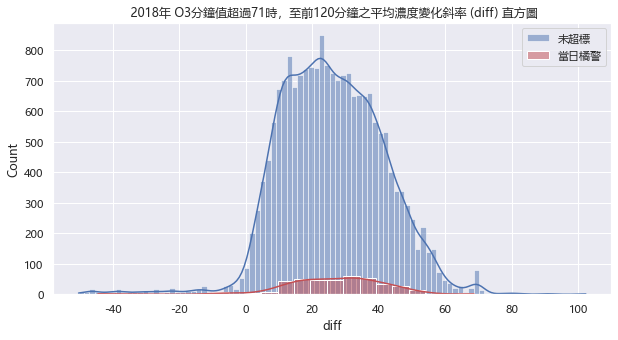

In [468]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

# 選擇變數
x = "diff"

# 拆分資料
exceeed = target_df_all_result[target_df_all_result["is_exceed_date"]]
not_exceeed = target_df_all_result[~target_df_all_result["is_exceed_date"]]

print(f"exceeed: {len(exceeed)}")
print(f"not_exceeed: {len(not_exceeed)}")

# 疊圖
fig, ax = plt.subplots(figsize=(10,5))
for idx, d in enumerate([not_exceeed, exceeed]):
    if idx==1:
        color = 'r'
        label = "當日橘警"
    else:
        color = 'b'
        label = "未超標"

    sns.histplot(data=d, x=x ,ax=ax, kde=True, color=color, label=label)
if x=="diff_ratio":
    ax.set_xlim(-0.1, 5)
ax.legend()
ax.set_title(f" 2018年 O3分鐘值超過71時，至前{early_hour*60}分鐘之平均濃度變化斜率 ({x}) 直方圖")

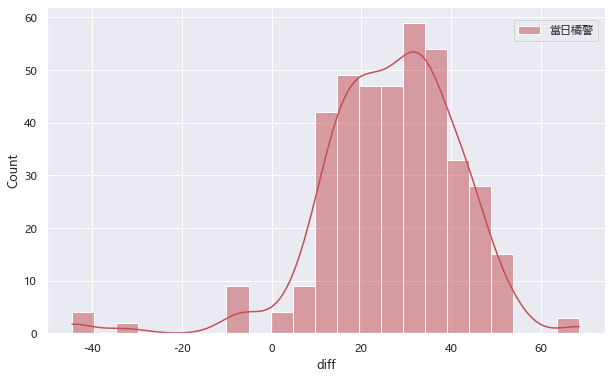

In [469]:
fig = plt.figure(figsize=(10,6))
color = 'r'
label = "當日橘警"
sns.histplot(data=exceeed, x="diff" , kde=True, color=color, label=label)
fig.legend(bbox_to_anchor=(0.89, 0.85), borderaxespad=0)

exceeed: 414
not_exceeed: 19947


Text(0.5, 1.0, ' 2018年 O3分鐘值超過71時，至前120分鐘之平均濃度變化斜率 (diff_ratio) 直方圖')

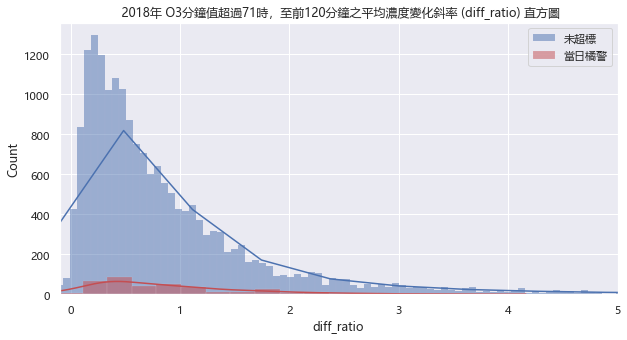

In [472]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False

# 選擇變數
x = "diff_ratio"

# 拆分資料
exceeed = target_df_all_result[target_df_all_result["is_exceed_date"]]
not_exceeed = target_df_all_result[~target_df_all_result["is_exceed_date"]]

print(f"exceeed: {len(exceeed)}")
print(f"not_exceeed: {len(not_exceeed)}")

# 疊圖
fig, ax = plt.subplots(figsize=(10,5))
for idx, d in enumerate([not_exceeed, exceeed]):
    if idx==1:
        color = 'r'
        label = "當日橘警"
    else:
        color = 'b'
        label = "未超標"
        
    sns.histplot(data=d, x=x ,ax=ax, kde=True, color=color, label=label)
    
if x=="diff_ratio":
    ax.set_xlim(-0.1, 5)
ax.legend()
ax.set_title(f" 2018年 O3分鐘值超過71時，至前{early_hour*60}分鐘之平均濃度變化斜率 ({x}) 直方圖")

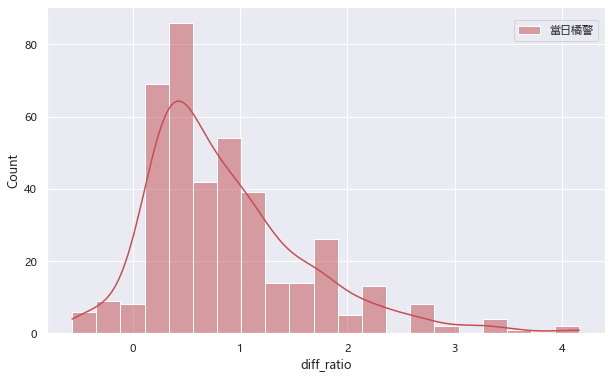

In [471]:
fig = plt.figure(figsize=(10,6))
color = 'r'
label = "當日橘警"
sns.histplot(data=exceeed, x="diff_ratio" , kde=True, color=color, label=label)
fig.legend(bbox_to_anchor=(0.89, 0.85), borderaxespad=0)

# 改寫成 Dask DataFrame (卡住.. 請先忽略)

In [123]:
# 讀檔
path = "E:/臭氧分鐘值_2018to2020/20210719T004146Z/481_國家級測站分鐘值_2018_01_0.csv" #2018 全年度
df_min = dd.read_csv(path, usecols=[0,3,124], parse_dates=["TIME"], dtype={0:"category", 124:"float32"})
# print(type(df_min))

# # 格式轉換
df_min = df_min.rename(columns={"O3()":"O3_min","TIME":"DataCreationDate"})

df_min['Date'] = df_min['DataCreationDate'].dt.date
df_min['Date'] = df_min['Date'].astype('category')

df_min.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, DEVICE_ID to Date
dtypes: category(2), datetime64[ns](1), float32(1)

In [129]:
# 系統運作時間 (7-1,21)
sys_working_zone = (6,21)
time_mask = (df_min["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min["DataCreationDate"].dt.hour <= sys_working_zone[1]) 

# 計算前五分鐘移動平均值
# 5分鐘移動平均(MA5)，可容忍5缺2筆
col = "O3_min"
col_name = col+"_MA5"

target_df_all = pd.DataFrame()
# for loop 區分 SiteName
for device_id in df_min["DEVICE_ID"].unique():
    mask = time_mask & df_min["DEVICE_ID"].isin([device_id])
    df_min_mask = df_min[mask]
    if len(df_min_mask.index) > 0:
    
        # 將負值設為空值
        df_min_mask[df_min_mask["O3_min"]<0]["O3_min"] = np.nan

#         # 創造 統一的時間區間*測站，還原缺值
#         r = pd.date_range(start=df_min_mask["DataCreationDate"].min(), end=df_min_mask["DataCreationDate"].max(), freq='1min')
#         df_min_mask = df_min_mask.set_index('DataCreationDate').reindex(r).fillna(
#                                         {'DEVICE_ID':device_id, 'O3_min':np.nan}).rename_axis('DataCreationDate').reset_index()

        # 製作 Date 變數
        df_min_mask['Date'] = df_min_mask['DataCreationDate'].dt.date
        df_min_mask['Date'] = df_min_mask['Date'].astype('category')
    
        # 計算5分鐘移動平均
        df_min_mask[col_name] = df_min_mask.sort_values(by=["DataCreationDate"], ascending=[1])[col].rolling(
                                    window=5, min_periods=3, center=False).mean().apply(
                                    lambda m: round(m, 3) if pd.notna(m) else np.nan , meta=('O3_min', 'float64'))


        # 找出每日早上7點之後(晚上9點之前)，第1次 分鐘值 超過71 的時間點與 當分鐘的MA5
        sys_working_zone = (7,21)
        time_mask = (df_min_mask["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min_mask["DataCreationDate"].dt.hour <= sys_working_zone[1]) 
        mask_exceed = time_mask & (df_min_mask["O3_min"] >= 71)
        df_min_mask_exceed = df_min_mask[mask_exceed]
        target_df = df_min_mask_exceed.sort_values(['DataCreationDate'], ascending=True).groupby(["DEVICE_ID", "Date"]).compute().head(1).reset_index(drop=True)
        
        
#         # 找出每日早上7點之後(晚上9點之前)，第1次 分鐘值 超過71 的時間點與 當分鐘的MA5
#         sys_working_zone = (7,21)
#         time_mask = (df_min_mask["DataCreationDate"].dt.hour >= sys_working_zone[0]) & (df_min_mask["DataCreationDate"].dt.hour <= sys_working_zone[1]) 
#         mask_exceed = time_mask & (df_min_mask["O3_min"] >= 71)
#         target_df = df_min_mask.sort_values(
#                                             ['DataCreationDate'], ascending=True).groupby(
#                                                                                     ["DEVICE_ID", "Date"]).first().reset_index()



        # # 找出目標分鐘前1小時的MA5，並合併 merge
        target_df["front_time"] = target_df['DataCreationDate'] - timedelta(hours=1)
        target_df = target_df.merge(df_min_mask, how='inner', 
                        left_on=["DEVICE_ID", "Date", 'front_time'], 
                        right_on=["DEVICE_ID", "Date", 'DataCreationDate'],
                        suffixes=("", "_front"))

        target_df_all = pd.concat([target_df_all, target_df.compute()])
        target_df_all = target_df_all.drop_duplicates()
        print(f">> DEVICE_ID: {device_id} 計算完成  Now: {datetime.now().time()}")
    
print(f"\n>>> 全部計算完成!  Now: {datetime.now()}")
target_df_all.reset_index(drop=True, inplace=True) # compute完 已經是 pandas.core.frame.DataFrame

AttributeError: 'Column not found: compute'

In [6]:
target_df_all

,DEVICE_ID,Date,DataCreationDate,O3_min,front_time,DataCreationDate_front,O3_min_front
0,6106537758,2018-01-03,2018-01-03 11:50:00,71.099998,2018-01-03 10:50:00,2018-01-03 10:50:00,43.000000
1,6106537758,2018-01-04,2018-01-04 11:39:00,71.800003,2018-01-04 10:39:00,2018-01-04 10:39:00,52.299999
2,6106537758,2018-01-13,2018-01-13 13:55:00,71.300003,2018-01-13 12:55:00,2018-01-13 12:55:00,61.700001
3,6106537758,2018-01-14,2018-01-14 10:18:00,72.400002,2018-01-14 09:18:00,2018-01-14 09:18:00,47.400002
4,6106537758,2018-01-15,2018-01-15 13:05:00,71.800003,2018-01-15 12:05:00,2018-01-15 12:05:00,55.599998
...,...,...,...,...,...,...,...
11,6097989748,2018-12-20,2018-12-20 14:13:00,100.199997,2018-12-20 13:13:00,2018-12-20 13:13:00,0.000000
12,6097989748,2018-12-21,2018-12-21 11:52:00,71.900002,2018-12-21 10:52:00,2018-12-21 10:52:00,0.000000
13,6097989748,2018-12-22,2018-12-22 11:36:00,71.400002,2018-12-22 10:36:00,2018-12-22 10:36:00,51.599998
14,6102800520,2018-12-21,2018-12-21 12:53:00,71.199997,2018-12-21 11:53:00,2018-12-21 11:53:00,65.000000


In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

target_df.visualize()

Reduce, and then use Pandas